## G4seeqer: A neural net to identify G4 structures


Technique:

* Predict G4 structures in the human genome using G4hunter - lots of false positives
* Use bedtools to extract G4seq %mm for predicted G4s.
* Train neural network to discriminate G4hunter false positives from true positives (classify using %mm)

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


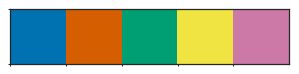

In [24]:
import os
from random import shuffle
from operator import itemgetter, add
from functools import reduce
from collections import Counter
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
from matplotlib import pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

%env KERAS_BACKEND tensorflow
from keras import layers, models, callbacks
from keras.utils import HDF5Matrix
import h5py

from g4seeqer.g4hunter import windowed_g4hunter
from g4seeqer.filter import filter_g4s, cluster_overlapping
from g4seeqer.neuralnet import one_hot_sequence, decode_ohe
from g4seeqer import mutmap

sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

## Data preprocessing

We reimplemented the G4hunter algorithm (Bedrat et al.) with some minor modifications. Bedrat et al's method run length encoded the sequence of interest and scored G-runs as the positive square of the run length, and C-runs as the negative square of the run length. The assumption was that a high G-content on both strands would make the G-Quadruplex unfavourable. Since we wish to make as few assumptions as possible, we altered the method to produce two scores. G runs score positively on the positive strand and C runs score positively on the negative strand. This means a sequence d(GGGCCC) will yield a high score on both strands rather than a single score of zero.

To produce training data for the neural network, we ran G4hunter with a window size of 50bp, a step size of 5bp, and a very low threshold (0.7), to capture as many positive G4 structures as possible. These were then increased in size by 39bp in each direction to include flanking sequence. Clusters of overlapping G4H sites were filtered to yield only the highest scoring sequence from each cluster. These were then intersected with the G4seq dataset to get their %mm scores.

In [18]:
with open('./data/hg19_g4hunter.bed', 'w') as bed:
    g4h_iter = windowed_g4hunter(
        '/home/matthew/iceberg_shared/General/mirror/genomes/faidx/hg19.fa',
        g4h_threshold=0.75,
        window_size=50,
        window_step=5
    )
    for *record, reverse, _ in filter_g4s(g4h_iter):
        strand = '-' if reverse else '+'
        bed.write('{}\t{:d}\t{:d}\tg4h\t{:.2f}\t{}\n'.format(*record, strand))

In [19]:
%%bash
source activate cgat_python2
sort -k1,1 -k2,2n ./data/hg19_g4hunter.bed > ./data/hg19_g4hunter.tmp.bed
mv ./data/hg19_g4hunter.tmp.bed ./data/hg19_g4hunter.bed
bedtools map -a <(awk '$6 == "+"' ./data/hg19_g4hunter.bed) \
  -b ./data/GSE63874_Na_K_12_minus.bdg -c 4 -o max | \
awk -v OFS='\t' '$7 != "."{print $1, $2, $3, $5, $7, $6}' > ./data/hg19_g4h_mm_plus.bed
bedtools map -a <(awk '$6 == "-"' ./data/hg19_g4hunter.bed) \
  -b ./data/GSE63874_Na_K_12_plus.bdg -c 4 -o max | \
awk -v OFS='\t' '$7 != "."{print $1, $2, $3, $5, $7, $6}' > ./data/hg19_g4h_mm_minus.bed
cat ./data/hg19_g4h_mm_plus.bed ./data/hg19_g4h_mm_minus.bed | \
sort -k1,1 -k2,2n > ./data/hg19_g4h_mm.bed
rm ./data/hg19_g4h_mm_plus.bed ./data/hg19_g4h_mm_minus.bed
head ./data/hg19_g4h_mm.bed

chr1	9965	10093	1.52	47.2	-
chr1	10095	10223	1.56	46.7	-
chr1	10245	10373	2.42	46.6	-
chr1	10380	10508	1.60	50.2	-
chr1	11095	11223	0.80	8.5	-
chr1	11235	11363	0.82	2.7	-
chr1	11365	11493	0.76	3.9	-
chr1	11895	12023	0.76	1.6	-
chr1	12230	12358	1.04	3.7	-
chr1	12540	12668	1.10	3.3	-


Plotting the distribution of the log of the %mm scores showed a bimodal distribution with a peak around 1 (corresponding to 2-3% mismatch) and another around 3.5 (corresponding to approximately 30% mismatch). We decided to use a threshold of 2.75 (around 15% mismatch) to split the data into G4 positive and G4 negative subsets. This yielded around 10 times more G4 negative sequences than positive, however. Since maintaining such an imbalance in the training data would produce a poor classifier, we undersampled the G4 negative class to produce a ratio of 2:1.

In [ ]:
data = pd.read_table(
    './data/hg19_g4h_mm.bed', sep='\t',
    names=['chrom', 'start', 'end', 'g4h_score', 'mm_score', 'strand'],
    usecols=['chrom', 'start', 'end', 'strand', 'g4h_score', 'mm_score'])
data.head()

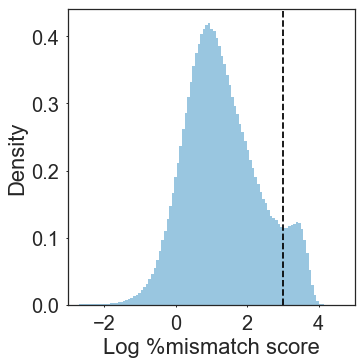

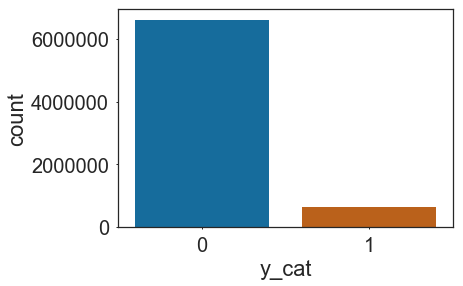

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))
jitter = np.random.normal(0, 0.05, size=len(data))
y = data.mm_score + jitter
y[y <= 0] = 0.01
h_y, h_x, *_ = ax.hist(np.log(y), alpha=0.4, bins=200, normed=True)
elbow = h_x[argrelextrema(h_y, np.less, order=5)[0]][-1]
ax.set_xlim(-3, 5)
ax.axvline(elbow, ls='--', color='k')
ax.set_xlabel('Log %mismatch score')
ax.set_ylabel('Density')
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('./figures/mm_score_hist.svg')
plt.show()

data['log_mm_score'] = np.log(data.mm_score)
data['y_cat'] = (data.log_mm_score > elbow).astype('i')
sns.countplot(data.y_cat)
plt.show()

In [22]:
elbow

2.9937138265947159

In [23]:
data['y_cat'].sum(), (1 - data['y_cat']).sum()

(639514, 6616241)

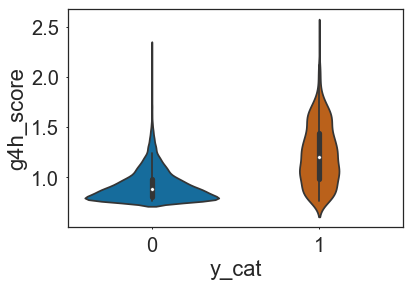

In [24]:
sns.violinplot(x='y_cat', y='g4h_score', data=data.sample(10000))
plt.show()

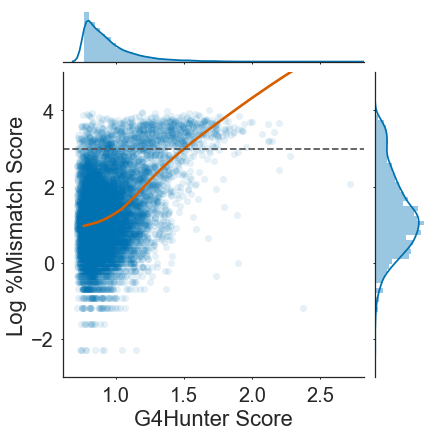

In [25]:
samp = data[data.log_mm_score > -3].sample(10000)
g = sns.JointGrid(x='g4h_score', y='log_mm_score', data=samp, size=6, ratio=5)
g.plot_joint(sns.regplot,
             lowess=True,
             x_jitter=0.05,
             scatter_kws={'alpha': 0.1, 'color': pal[0], 'rasterized': True},
             line_kws={'color': pal[1]})
g.ax_joint.set_ylim(-3, 5)
g.ax_joint.axhline(y=elbow, ls='--', c='#555555')
g.plot_marginals(sns.distplot)
g.ax_joint.set_xlabel('G4Hunter Score')
g.ax_joint.set_ylabel('Log %Mismatch Score')
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('./figures/g4h_mm_joint.svg')
plt.show()

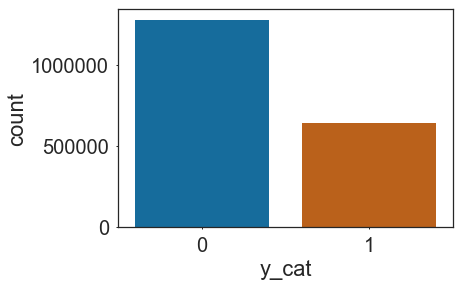

In [26]:
def ratio(y):
    return {0: int(2 * y.sum()), 1: int(y.sum())}

rus = RandomUnderSampler(ratio=ratio)
idx, y_resampled = rus.fit_sample(np.arange(len(y)).reshape(-1, 1), data.y_cat)
data_resampled = data.iloc[idx.ravel()]
sns.countplot(data_resampled.y_cat)
plt.show()

In [27]:
len(data_resampled)

1918542

In [28]:
data_resampled.to_csv(
    './data/hg19_g4h_mm_resampled.tmp.bed', sep='\t',
    columns=['chrom', 'start', 'end', 'g4h_score', 'mm_score', 'strand'],
    header=False,
    index=False,
)
!shuf ./data/hg19_g4h_mm_resampled.tmp.bed > ./data/hg19_g4h_mm_resampled.bed
!rm ./data/hg19_g4h_mm_resampled.tmp.bed
!head ./data/hg19_g4h_mm_resampled.bed

chr7	113959155	113959283	1.16	21.6	+
chr19	50249740	50249868	1.3	21.0	-
chr7	156013015	156013143	0.96	3.2	+
chrX	111161735	111161863	0.8	1.9	+
chr8	23162280	23162408	0.94	3.1	-
chr11	85710840	85710968	0.9	1.1	-
chr14	87607320	87607448	0.9	2.7	-
chr6	101356105	101356233	1.48	38.3	-
chr13	44815800	44815928	0.98	2.7	-
chr2	219897110	219897238	1.04	4.8	-


In [29]:
%%bash
source activate cgat_python2
bedtools getfasta -s -tab\
  -fi /home/matthew/iceberg_shared/General/mirror/genomes/faidx/hg19.fa \
  -bed ./data/hg19_g4h_mm_resampled.bed \
  -fo stdout | paste ./data/hg19_g4h_mm_resampled.bed - | \
cut -f1-6,8 > ./data/hg19_g4h_mm_seq.bed
head ./data/hg19_g4h_mm_seq.bed | cut -c-80

chr7	113959155	113959283	1.16	21.6	+	ggctacatttttaacctggtgaatgggctaatgcctatttgtt
chr19	50249740	50249868	1.3	21.0	-	GCCCGCCAGGGAGTCCCGACAAACCCTCGCGGCCACACGGCCTGG
chr7	156013015	156013143	0.96	3.2	+	TCCAGAGCGTGTGAACACAGTGAGCAGGCATTCGGGGTGAGCGC
chrX	111161735	111161863	0.8	1.9	+	gcttttttttttctctctagcagctttgacagtccagatgtgggg
chr8	23162280	23162408	0.94	3.1	-	TATCCTGTTCATTGCTGTCTTCCCCGTTCCCCGTGCCCCCACTGCC
chr11	85710840	85710968	0.9	1.1	-	ctacagatatctgagtcccaatcctagagttttgattcagtaggtg
chr14	87607320	87607448	0.9	2.7	-	TACTTTGCTGCTGATTTGGGTATCTTGTTTAAAAGAAAATCAGCTT
chr6	101356105	101356233	1.48	38.3	-	cataggtgggaattgaacaatgagaacacgtggacactggaag
chr13	44815800	44815928	0.98	2.7	-	AGCTGGAACCTGTGGACATTCTTTCCCTGTCCGTGCTCTGCTGTG
chr2	219897110	219897238	1.04	4.8	-	CAGGCATAACCCTCACGCTCCCCATCGTCTTCCGGCCTCTGGAG


In [30]:
import itertools as it

TRINUCLS = [''.join(t) for t in it.product('ACGT', repeat=3)]
TRINUCLS.append('NNN')

def trinucl_composition(seq):
    seq = seq.upper()
    trinucls = {k: 0 for k in TRINUCLS}
    for i in range(len(seq) - 2):
        try:
            trinucls[seq[i: i + 3]] += 1
        except:
            trinucls['NNN'] += 1
    trinucls = np.array([trinucls[t] for t in TRINUCLS])
    return trinucls / trinucls.sum()


seq_ohe = {'A': [1, 0, 0, 0],
           'C': [0, 1, 0, 0],
           'G': [0, 0, 1, 0],
           'T': [0, 0, 0, 1],
           'N': [0, 0, 0, 0]}


def one_hot_sequence(seq):
    ohe = []
    seq = seq.upper()
    if len(seq) < 128:
        seq = seq + 'N' * (128 - len(seq))
    for base in seq:
        try:
            ohe.append(seq_ohe[base])
        except KeyError:
            ohe.append(seq_ohe['N'])
    return np.asarray(ohe)


def load_data(data_fn, chrom_sizes, h5_fn, chunksize=100000):
    length = !wc -l {data_fn}
    length = int(length[0].split()[0])
    with open(chrom_sizes) as f:
        ref_names = [line.split('\t')[0].encode('utf-8') for line in f.readlines()]
        ref_id_map = {name: i for i, name in enumerate(ref_names)}
    with h5py.File(h5_fn, 'w') as h5_file:
        X = h5_file.create_dataset('X',
                                   shape=(length, 128, 4),
                                   dtype=np.uint8,
                                   chunks=(chunksize, 128, 4))
        X_trinucl = h5_file.create_dataset('X_trinucl',
                                           shape=(length, len(TRINUCLS)),
                                           dtype=np.float32,
                                           chunks=(chunksize, len(TRINUCLS)))
        y = h5_file.create_dataset('y',
                                   shape=(length, ),
                                   dtype=np.float32,
                                   chunks=(chunksize, ))
        y_cat = h5_file.create_dataset('y_cat',
                                       shape=(length,),
                                       dtype=np.uint8,
                                       chunks=(chunksize,))
        g4h = h5_file.create_dataset('g4h',
                                     shape=(length, ),
                                     dtype=np.float32,
                                     chunks=(chunksize, ))
        ref_ids = h5_file.create_dataset('ref_ids',
                                         dtype=np.uint8,
                                         shape=(length, ),
                                         chunks=(chunksize,))
        ref_ids.attrs['ref_names'] = ref_names
        pos = h5_file.create_dataset('pos',
                                     dtype=np.int32,
                                     shape=(length, 2),
                                     chunks=(chunksize, 2))
        with open(data_fn) as inp:
            ref_ids_chunk = []
            pos_chunk = []
            X_chunk = []
            X_t_chunk = []
            y_chunk = []
            y_cat_chunk = []
            g4h_chunk = []
            i = 0
            for j, record in enumerate(inp):
                chrom, start, end, g4h_score, mm_score, _, seq = record.split()
                ref_ids_chunk.append(ref_id_map[chrom.encode('utf-8')])
                pos_chunk.append([int(start), int(end)])
                g4h_chunk.append(float(g4h_score))
                mm_score = max(float(mm_score), 0.01)
                log_mm_score = np.log(mm_score)
                y_chunk.append(mm_score)
                y_cat_chunk.append(log_mm_score > 2.75)
                X_chunk.append(one_hot_sequence(seq))
                X_t_chunk.append(trinucl_composition(seq))
                if len(y_chunk) == chunksize:
                    ref_ids[i:j + 1] = ref_ids_chunk
                    pos[i:j + 1] = pos_chunk
                    X[i:j + 1] = X_chunk
                    X_trinucl[i:j + 1] = X_t_chunk
                    y[i:j + 1] = y_chunk
                    y_cat[i:j + 1] = y_cat_chunk
                    g4h[i:j + 1] = g4h_chunk

                    ref_ids_chunk = []
                    pos_chunk = []
                    X_chunk = []
                    X_t_chunk = []
                    y_chunk = []
                    y_cat_chunk = []
                    g4h_chunk = []
                    i = j + 1
            if y_chunk:
                ref_ids[i:] = ref_ids_chunk
                pos[i:] = pos_chunk
                X[i:] = X_chunk
                X_trinucl[i:j + 1] = X_t_chunk
                y[i:] = y_chunk
                g4h[i:] = g4h_chunk
                y_cat[i:] = y_cat_chunk


load_data('./data/hg19_g4h_mm_seq.bed', './data/hg19.chrom.sizes', './data/hg19_g4h_mm_seq.h5')

### G4RNA style model

In [3]:
g4rna = models.Sequential()
g4rna.add(layers.Dense(16,
                       input_shape=(4 ** 3 + 1, ),
                       activation='relu'))
g4rna.add(layers.Dropout(0.2))
g4rna.add(layers.Dense(16,
                       activation='relu'))
g4rna.add(layers.Dropout(0.2))
g4rna.add(layers.Dense(16,
                       activation='relu'))
g4rna.add(layers.Dropout(0.2))
g4rna.add(layers.Dense(1, activation='sigmoid'))
g4rna.compile(optimizer='adam', loss='binary_crossentropy')
g4rna.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

In [4]:
X_t = HDF5Matrix('./data/hg19_g4h_mm_seq.h5', 'X_trinucl', end=1145953)
y = HDF5Matrix('./data/hg19_g4h_mm_seq.h5', 'y_cat', end=1145953)

early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         min_delta=0.0005,
                                         patience=3)

g4rna.fit(X_t, y,
          validation_split=1/9,
          batch_size=128,
          epochs=30,
          shuffle='batch',
          callbacks=[early_stopping,],
          verbose=2)

Train on 1018624 samples, validate on 127329 samples
Epoch 1/30
10s - loss: 0.4188 - val_loss: 0.3934
Epoch 2/30
9s - loss: 0.4027 - val_loss: 0.3892
Epoch 3/30
9s - loss: 0.4017 - val_loss: 0.3895
Epoch 4/30
9s - loss: 0.4008 - val_loss: 0.3881
Epoch 5/30
9s - loss: 0.4003 - val_loss: 0.3881
Epoch 6/30
9s - loss: 0.3999 - val_loss: 0.3891
Epoch 7/30
9s - loss: 0.3997 - val_loss: 0.3891
Epoch 8/30
9s - loss: 0.3993 - val_loss: 0.3891


In [5]:
g4rna.save('../g4seeqer/data/g4_trinucl_mlp_weights.h5')

In [30]:
g4rna = models.load_model('../g4seeqer/data/g4_trinucl_mlp_weights.h5')

In [27]:
g4seeqer = models.Sequential()
g4seeqer.add(layers.Conv1D(8,
                           kernel_size=3,
                           input_shape=(128, 4),
                           activation='relu'))
g4seeqer.add(layers.Conv1D(8, kernel_size=3, activation='relu'))
g4seeqer.add(layers.MaxPool1D(2))
g4seeqer.add(layers.Bidirectional(layers.LSTM(8)))
g4seeqer.add(layers.Dense(16, activation='relu'))
g4seeqer.add(layers.Dropout(0.5))
g4seeqer.add(layers.Dense(1, activation='sigmoid'))
g4seeqer.compile(optimizer='rmsprop', loss='binary_crossentropy')
g4seeqer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 126, 8)            104       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 124, 8)            200       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 62, 8)             0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 16)                1088      
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total para

In [28]:
X = HDF5Matrix('./data/hg19_g4h_mm_seq.h5', 'X', end=1145953)
y = HDF5Matrix('./data/hg19_g4h_mm_seq.h5', 'y_cat', end=1145953)

early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         min_delta=0.0005,
                                         patience=3)

g4seeqer.fit(X, y,
             validation_split=1/9,
             batch_size=128,
             epochs=30,
             shuffle='batch',
             callbacks=[early_stopping,],
             verbose=2)

Train on 1018624 samples, validate on 127329 samples
Epoch 1/30
376s - loss: 0.3850 - val_loss: 0.3140
Epoch 2/30
374s - loss: 0.3390 - val_loss: 0.3075
Epoch 3/30
374s - loss: 0.3323 - val_loss: 0.3099
Epoch 4/30
374s - loss: 0.3281 - val_loss: 0.3212
Epoch 5/30
375s - loss: 0.3248 - val_loss: 0.2990
Epoch 6/30
374s - loss: 0.3224 - val_loss: 0.2960
Epoch 7/30
374s - loss: 0.3213 - val_loss: 0.2995
Epoch 8/30
374s - loss: 0.3197 - val_loss: 0.2963
Epoch 9/30
374s - loss: 0.3184 - val_loss: 0.2936
Epoch 10/30
373s - loss: 0.3179 - val_loss: 0.2975
Epoch 11/30
373s - loss: 0.3168 - val_loss: 0.2912
Epoch 12/30
373s - loss: 0.3160 - val_loss: 0.2926
Epoch 13/30
373s - loss: 0.3154 - val_loss: 0.2927
Epoch 14/30
375s - loss: 0.3139 - val_loss: 0.2910
Epoch 15/30
374s - loss: 0.3135 - val_loss: 0.2945


In [29]:
g4seeqer.save('../g4seeqer/data/g4seeqer_weights_with_dropout.h5')

In [29]:
g4seeqer = models.load_model('../g4seeqer/data/g4seeqer_weights.h5')

In [83]:
with h5py.File('./data/hg19_g4h_mm_seq.h5') as f:
    ref_ids = f['ref_ids'][-127328:]
    ref_names = f['ref_ids'].attrs['ref_names'][ref_ids]
    pos = f['pos'][-127328:]
    start, end = pos.T
    X_test = f['X'][-127328:]
    X_t_test = f['X_trinucl'][-127328:]
    y_test = f['y_cat'][-127328:]
    y_score_test = f['y'][-127328:]
    g4h_pred = f['g4h'][-127328:]

y_pred = g4seeqer.predict(X_test, batch_size=128)
y_pred_trinucl = g4rna.predict(X_t_test, batch_size=128)

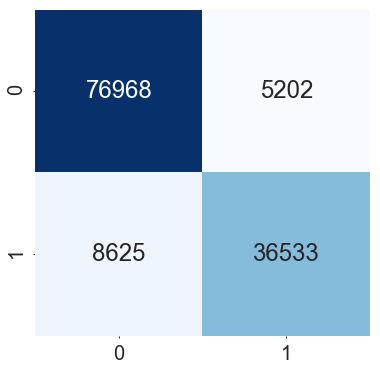

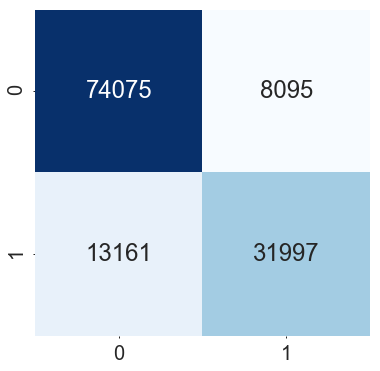

In [84]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred > 0.5)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.get_cmap('Blues'), cbar=False)
plt.show()

cm = confusion_matrix(y_test, y_pred_trinucl > 0.5)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.get_cmap('Blues'), cbar=False)
plt.show()

0.823641647209
0.890594818508
0.936401226717


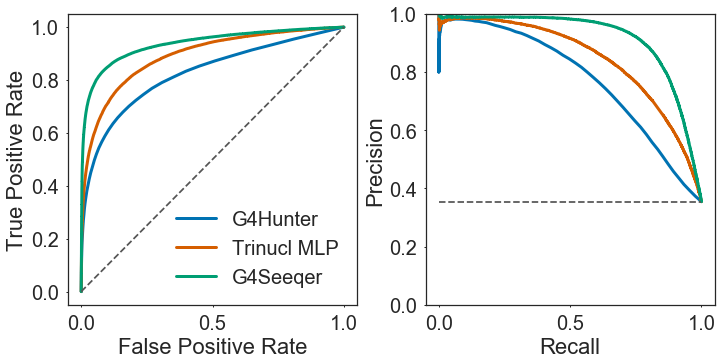

In [85]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
for s, lab in zip([g4h_pred, y_pred_trinucl, y_pred], ['G4Hunter', 'Trinucl MLP', 'G4Seeqer']):
    fpr, tpr, threshold_roc = roc_curve(y_test, s)
    print(auc(fpr, tpr))
    axes[0].plot(fpr, tpr, linewidth=3, label=lab)
    prec, recl, threshold_pr = precision_recall_curve(y_test, s)
    axes[1].plot(recl, prec, linewidth=3)
axes[0].plot([0, 1], [0, 1], color='#555555', ls='--')
axes[1].plot([0, 1], [prec[0], prec[0]], color='#555555', ls='--')
axes[1].set_ylim([0, 1])
axes[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
axes[1].set(xlabel='Recall', ylabel='Precision')
axes[0].legend(loc=4, )
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('figures/test_set_roc_pr.svg')
plt.show()

In [86]:
with open('./data/test_set.bed', 'w') as test_bed:
    for chrom, s, e, y in zip(ref_names, start, end, y_test):
        test_bed.write('{}\t{:d}\t{:d}\t{:d}\n'.format(
            chrom.decode('utf-8'), s - 50, e + 50, y))
!head ./data/test_set.bed

chr7	45912720	45912948	0
chr9	87110510	87110738	0
chr8	142541685	142541913	0
chr11	8371935	8372163	0
chr7	92475165	92475393	0
chr11	99483970	99484198	0
chr17	35290725	35290953	1
chr2	41382155	41382383	1
chr20	47605825	47606053	0
chr5	95917875	95918103	0


In [87]:
%%bash
source activate cgat_python2
bedtools getfasta \
  -fi /home/matthew/iceberg_shared/General/mirror/genomes/faidx/hg19.fa \
  -bed ./data/test_set.bed \
  -fo ./data/test_set.fa
head ./data/test_set.fa

>chr7:45912720-45912948
GAGCCCACCCGAGCCAGAGTTAGCCTGACGGCCACGCCATTGCACAGGTGTGGGGCAGGTTTCCCTCGCCCTCTAGGTCTTCCCCTTGTTGGTTTCTGTTGTGTGCACCTGAGCCTGTGGGAAGTGAAGGCTGGCTGGGCACTTGCGCCCCACCCCCCCACCCCCCAGCAACAAGCCACCTGTGCCAAATACTGTTTGATGTGCATCATAACCACCTACGGGAAAGGA
>chr9:87110510-87110738
tttgtttgtttgtttgtttgtttatttttgagatggaatcatcttctgttatccaggctggagtgcagtggtgcgatctcagctcaccgcaacctgggcctcccaggttcaagcaattctccttgcttcagcctcccgagtaactgggattacaggcacatgccatgcttggctaatttttgtatttttagtagagacacggttttgccaagttggccaggctggtct
>chr8:142541685-142541913
GCTGCAGCAATAAATGCGATTAACTCCTTATGAAGTCTTCTACTTACATTTTTCAAAAAGTGATGCTGATTTTCGACTGGGGACTGCAGAGAGCCTGGAGCCCTGTCACGTCCCTGCGCTTCCCCCCTTACTGCGtcagagtgcgtcagagctgcgagggaacctcacgatccgcatgtgaaacctgctgcttcccagaaaggaggtgggggccagaggaggccgggg
>chr11:8371935-8372163
AGCCAACAAATGAGGCTAGGAACAGGCTGAGCTAAGCCAGCTGAGAAGCATCGGATGCCCCCGCCCTGCCCCACACTGACACACACCCTCTGGGGCACACAACAGGGAAGCTCAGGGGGTGACAGCTCACATCTCACCTTCCCGTGCAGGGACTTTGGTCTCCCCCATGCCACTCTTCTGGTGCCAGCCACCCTCATCTTGCACTAGAAGGCTCTG

In [88]:
%%bash
source activate quadron
Quadron.R ./data/test_set.fa ./data/test_set_quadron.txt
grep "DATA:" ./data/test_set_quadron.txt | \
grep -v "NA" > ./data/test_set_quadron.filt.txt

[1] NOTE: Loading Quadron core...
[1] NOTE: *:)* Sequence-Based Prediction of DNA Quadruplex Structures *(:*
[1] NOTE: Date - Fri Apr 20 20:24:20 2018
[1] NOTE: Parsing the sequence...
[1] NOTE: The digested sequence is of 29030784-nt length.
[1] NOTE: Scanning the sequence for G4 motifs...
[1] NOTE: Extracting features using 4 processing core(s).
[1] NOTE: Pre-processing the extracted features...
[1] NOTE: Executing the Quadron core...
[1] NOTE: Formatting and saving the results...
[1] NOTE: Quadron is done!
 [1] "NOTE: *:)* Sequence-Based Prediction of DNA Quadruplex Structures *(:*"        
 [2] "NOTE: Date - Fri Apr 20 20:24:20 2018"                                         
 [3] "NOTE: Parsing the sequence..."                                                 
 [4] "NOTE: The digested sequence is of 29030784-nt length."                         
 [5] "NOTE: Scanning the sequence for G4 motifs..."                                  
 [6] "NOTE: Extracting features using 4 processing core

In [90]:
!head ./data/test_set_quadron.filt.txt

DATA:      148 -  19 23.23 CCCCACCCCCCCACCCCCC
DATA:     1460 +  26 29.38 GGGGGCGGGGGCGGGGGAAGGAAGGG
DATA:     1683 -  34 25.43 CCCTCCCCCCTCCCCCCACCCCGCAACAGGCCCC
DATA:     3512 -  64 24.51 CCCCTTCCCCTTCCCCTCCCCCCATCCATCCCTCCCTCCCTCCCTCCCTCCCTCCCTCCCTCCC
DATA:     5535 -  55  5.32 CCCTTGGGGCTCCCGGTGGCAGAGCCCTCCCTGAGAATCACCCGCTATAAGCCCC
DATA:     6079 +  29 16.17 GGGAGGAGGCAGTGTGGGCTGGGCTGGGG
DATA:     7013 +  50  3.20 GGGCATGGCTACCTGGGAAAGATGAGTAGGGCCCAGATGGGGATTGAGGG
DATA:     7173 +  34 16.16 GGGAGAGAAATGGGAGAACGGCTGGTGGGTGGGG
DATA:     7630 +  26 25.84 GGGGTGGGAGAGGAAAGGGGCTGGGG
DATA:     8072 +  28 35.92 GGGGGAGGGAGGCATACTATTGGGTGGG


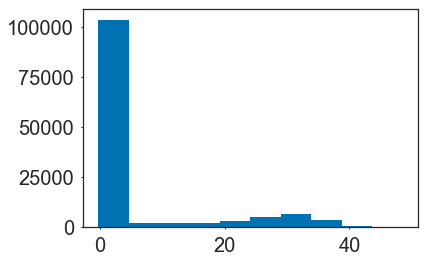

In [121]:
n_records = !wc -l ./data/test_set.bed | cut -d " " -f1
n_records = int(n_records[0])
quadron_scores = np.zeros(n_records, dtype='f')
is_quadparser = np.zeros(n_records, dtype=bool)
with open('./data/test_set_quadron.filt.txt') as qp:
    for record in qp:
        _, start, strand, length, score, _ = record.split()
        start = int(start)
        end = start + int(length)
        i, m = divmod(start, 228)
        j, n = divmod(end, 228)
        if i == j and m >= 50 and n <= 178:
            quadron_scores[i] = float(score)
            is_quadparser[i] = True
plt.hist(quadron_scores)
plt.show()

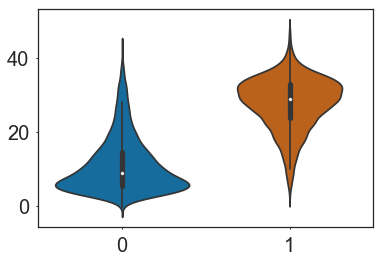

In [122]:
sns.violinplot(x=y_test[quadron_scores != 0], y=quadron_scores[quadron_scores != 0])
plt.show()

0.936401226717
0.823641647209
0.705299596657
0.890594818508


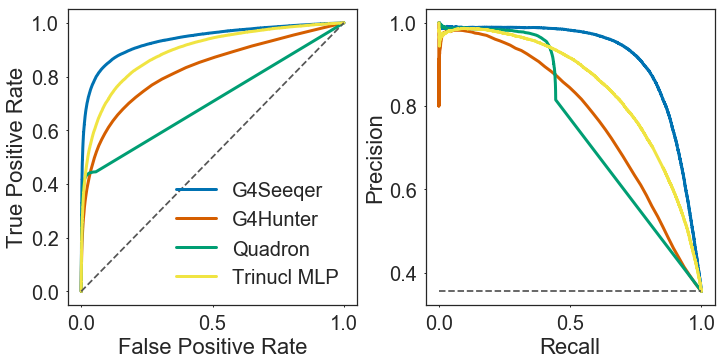

0.940279179719
0.783311878642
0.928913050804
0.843590003639


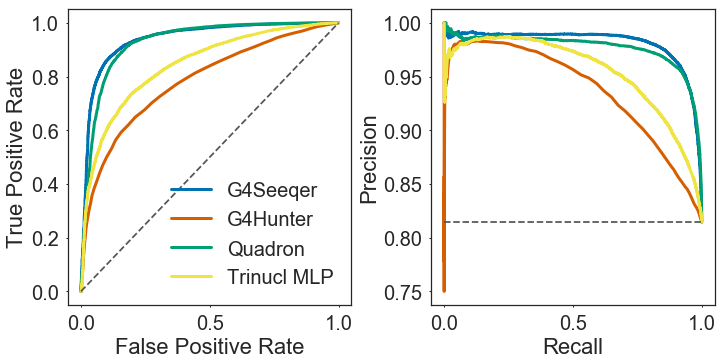

In [206]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
for s, lab in zip([y_pred, g4h_pred, quadron_scores, y_pred_trinucl],
                   ['G4Seeqer', 'G4Hunter', 'Quadron', 'Trinucl MLP']):
    fpr, tpr, threshold_roc = roc_curve(y_test, s)
    print(auc(fpr, tpr))
    axes[0].plot(fpr, tpr, linewidth=3, label=lab)
    prec, recl, threshold_pr = precision_recall_curve(y_test, s)
    axes[1].plot(recl, prec, linewidth=3)

axes[0].plot([0, 1], [0, 1], color='#555555', ls='--')
axes[1].plot([0, 1], [prec[0], prec[0]], color='#555555', ls='--')
#axes[1].set_ylim([0, 1])
axes[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
axes[1].set(xlabel='Recall', ylabel='Precision')
axes[0].legend(loc=4, )
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('figures/test_set_roc_pr.svg')
plt.show()

fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
for s, lab in zip([y_pred, g4h_pred, quadron_scores, y_pred_trinucl],
                   ['G4Seeqer', 'G4Hunter', 'Quadron', 'Trinucl MLP']):
    fpr, tpr, threshold_roc = roc_curve(y_test[is_quadparser],
                                        s[is_quadparser])
    print(auc(fpr, tpr))
    axes[0].plot(fpr, tpr, linewidth=3, label=lab)
    prec, recl, threshold_pr = precision_recall_curve(
        y_test[is_quadparser], s[is_quadparser])
    axes[1].plot(recl, prec, linewidth=3)

axes[0].plot([0, 1], [0, 1], color='#555555', ls='--')
axes[1].plot([0, 1], [prec[0], prec[0]], color='#555555', ls='--')
#axes[1].set_ylim([0, 1])
axes[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
axes[1].set(xlabel='Recall', ylabel='Precision')
axes[0].legend(loc=4, )
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('figures/test_set_roc_pr_quadparser_only.svg')
plt.show()

In [138]:
%%bash
source activate cgat_python2
wget -O - \
  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE76nnn/GSE76688/suppl/GSE76688_rhh_25cyc_BG4_12082015_peaks.narrowPeak.gz | \
zcat |
awk -v OFS='\t' '{if ($2 < 50){start=0}else{start=$2-50}; \
                 print $1, start, $3 + 50, $1":"start"-"$3+50":1"}' > ./data/BG4_pos.bed
bedtools shuffle -chrom \
  -excl <(cat ./data/hg19_gaps.bed ./data/BG4_pos.bed | cut -f1-3 | sort -k1,1 -k2,2n) \
  -g ./data/hg19.chrom.sizes \
  -i ./data/BG4_pos.bed | \
awk -v OFS='\t' '{print $1, $2, $3, $1":"$2"-"$3":0"}' > ./data/BG4_neg.bed
cat ./data/BG4_pos.bed ./data/BG4_neg.bed | \
sort -k1,1 -k2,2n > ./data/BG4_test_set.bed
bedtools getfasta -name \
  -fi /home/matthew/iceberg_shared/General/mirror/genomes/faidx/hg19.fa \
  -bed ./data/BG4_test_set.bed \
  -fo ./data/BG4_test_set.fa
head ./data/BG4_test_set.fa

>chr1:244257-244674:0
aagctttaaCAATCTGAGAGACATTCATACATTTTCCATGTGCTGTAGCCTTATACCCAAAGCCTGGGTCCCAAGTGACCATGACAGGCAGAGCTCCCTGGTGagccacagagatttagagaatggctgttaacacagcataatccagcccatcctgactaatCTGATATTAACATGTATAATAAAGAATTCTATCAATGCTGAGGGAAGATGACTAGTTAAGGTCCTAGGTTGCAAGTCTCAAAACCTCTTCTAAGGATTGTAGACAGGAAATTAAATGACTTCTAGTCCCTAGAGTTCCCAATCTCCTACCATCCCATCCTAATATGACAGAAGTAATTCCTGAGTTGCTTCTGAAACCAGAGCTTCCCTCAGAACCCTTAGCCTGCCAGATGGCTTCTTGGAGAGCCCTCACTC
>chr1:392272-392506:0
ggagccttcaaactgttctccataggggatgtacttgtattcttcaaaattgctaagagtagatttttaagtgttctcataaaaaaagataagcatgtaaggtaatgcatatgttagcttaacatggctattttacaatgaatatatatttcaaaacatATAATTTTATTTATCTGATAAAATAAATATAAAAtatgaaactttatattaataaatttgacaatcataaggaat
>chr1:543377-543682:0
ACAGGTTCACACAGCACGTTTTCTGCTCCATCACGTGTATGGGGCAGGGGGCAGCAGAGCTGGGGGAGAAGAGATAAAGGAATTATGTCAAACAGGGACTGTCTTGTCTGCCCCAAGGGCCTTTCCTCATCTATAAAGCAGATTTTTCTTGTAGAGCACCACGAGAGCTGTGAAATGGGAGTGAGGGGTGAGGCAGGCCATGGGGCCTTCCACAAGGTGGGCAAGATGGTTGTCTCTGGGGAACCAGCTGGCCAGAGGGGGCCAAGTGCCAACCGGTCTGG

--2018-04-21 10:35:33--  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE76nnn/GSE76688/suppl/GSE76688_rhh_25cyc_BG4_12082015_peaks.narrowPeak.gz
           => ‘-’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.230, 2607:f220:41e:250::12
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.230|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/series/GSE76nnn/GSE76688/suppl ... done.
==> SIZE GSE76688_rhh_25cyc_BG4_12082015_peaks.narrowPeak.gz ... 395107
==> PASV ... done.    ==> RETR GSE76688_rhh_25cyc_BG4_12082015_peaks.narrowPeak.gz ... done.
Length: 395107 (386K) (unauthoritative)

     0K .......... .......... .......... .......... .......... 12%  217K 2s
    50K .......... .......... .......... .......... .......... 25%  603K 1s
   100K .......... .......... .......... .......... .......... 38% 58.2M 0s
   150K .......... .......... .......... .......... .......... 51%

In [141]:
%%bash
source activate quadron
Quadron.R ./data/BG4_test_set.fa ./data/BG4_test_set.txt
grep "DATA:" ./data/BG4_test_set.txt | \
grep -v "NA" > ./data/BG4_test_set.filt.txt
head ./data/BG4_test_set.filt.txt

[1] NOTE: Loading Quadron core...
[1] NOTE: *:)* Sequence-Based Prediction of DNA Quadruplex Structures *(:*
[1] NOTE: Date - Sat Apr 21 10:41:09 2018
[1] NOTE: Parsing the sequence...
[1] NOTE: The digested sequence is of 14541432-nt length.
[1] NOTE: Scanning the sequence for G4 motifs...
[1] NOTE: Extracting features using 4 processing core(s).
[1] NOTE: Pre-processing the extracted features...
[1] NOTE: Executing the Quadron core...
[1] NOTE: Formatting and saving the results...
[1] NOTE: Quadron is done!
 [1] "NOTE: *:)* Sequence-Based Prediction of DNA Quadruplex Structures *(:*"        
 [2] "NOTE: Date - Sat Apr 21 10:41:09 2018"                                         
 [3] "NOTE: Parsing the sequence..."                                                 
 [4] "NOTE: The digested sequence is of 14541432-nt length."                         
 [5] "NOTE: Scanning the sequence for G4 motifs..."                                  
 [6] "NOTE: Extracting features using 4 processing core

In [188]:
starts = []
ends = []
bg4_y = []
bg4_invs = !grep "^>" ./data/BG4_test_set.fa
bg4_invs = [x.strip()[1:] for x in bg4_invs]
for record in bg4_invs:
    start, end, y = re.match("chr.+:(\d+)-(\d+):(\d)", record).groups()
    starts.append(int(start))
    ends.append(int(end))
    bg4_y.append(int(y))
starts = np.array(starts)
ends = np.array(ends)
lengths = ends - starts
cum_lengths = np.cumsum(lengths)
bg4_y = np.array(bg4_y)

quadron_bg4_scores = pd.read_table(
    './data/BG4_test_set.filt.txt',
    sep='\s+',
    names=['_', 'start', 'strand', 'length', 'quadron_score', 'seq'],
    usecols=['start', 'strand', 'length', 'quadron_score']
)
quadron_bg4_scores['end'] = quadron_bg4_scores.start + quadron_bg4_scores.length
start_idx = np.searchsorted(cum_lengths, quadron_bg4_scores.start)
end_idx = np.searchsorted(cum_lengths, quadron_bg4_scores.end)
same_inv = start_idx == end_idx
start_not_in_flank = quadron_bg4_scores.start - cum_lengths[start_idx - 1] >= 50
end_not_in_flank = cum_lengths[end_idx] - quadron_bg4_scores.end >= 50
quadron_bg4_scores = quadron_bg4_scores[same_inv & start_not_in_flank & end_not_in_flank]
start_idx = start_idx[same_inv & start_not_in_flank & end_not_in_flank]
quadron_bg4_scores['inv'] = np.array(bg4_invs)[start_idx]
quadron_bg4_scores = quadron_bg4_scores[['inv', 'quadron_score']].groupby('inv').max()
quadron_bg4_scores = quadron_bg4_scores.reindex(bg4_invs).fillna(0)
quadron_bg4_scores['y_true'] = bg4_y
quadron_bg4_scores.head()

,quadron_score,y_true
inv,,
chr1:244257-244674:0,0.0,0
chr1:392272-392506:0,0.0,0
chr1:543377-543682:0,0.0,0
chr1:588882-589359:0,0.0,0
chr1:683236-683689:0,0.0,0


In [191]:
%%bash
source activate ml_python35
g4seeqer -tg 0.75 -ts 0 -p 6 \
  -f ./data/BG4_test_set.fa \
  -b ./data/BG4_test_set_g4seeqer.bed

2018-04-21 11:25:55.382623: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
Using TensorFlow backend.
Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.Session object at 0x7f9244d53278>>
Traceback (most recent call last):
  File "/home/matthew/anaconda3/envs/ml_python35/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 696, in __del__
TypeError: 'NoneType' object is not callable


In [202]:
g4seeqer_bg4_scores = pd.read_table(
    './data/BG4_test_set_g4seeqer.bed',
    sep='\t',
    names=['inv', 'start', 'end', 'g4seeqer_score', 'g4hunter_score', 'strand'],
    usecols=['inv', 'g4seeqer_score', 'g4hunter_score'],
)
g4seeqer_bg4_scores = g4seeqer_bg4_scores.groupby('inv').max()
bg4_val_data = quadron_bg4_scores.join(g4seeqer_bg4_scores, how='left').fillna(0)
bg4_val_data.head()

,quadron_score,y_true,g4seeqer_score,g4hunter_score
inv,,,,
chr1:244257-244674:0,0.0,0,0.039672,0.84
chr1:392272-392506:0,0.0,0,0.000000,0.00
chr1:543377-543682:0,0.0,0,0.682165,1.30
chr1:588882-589359:0,0.0,0,0.000000,0.00
chr1:683236-683689:0,0.0,0,0.030317,0.82


0.71437976492
0.701305867123
0.583401954486


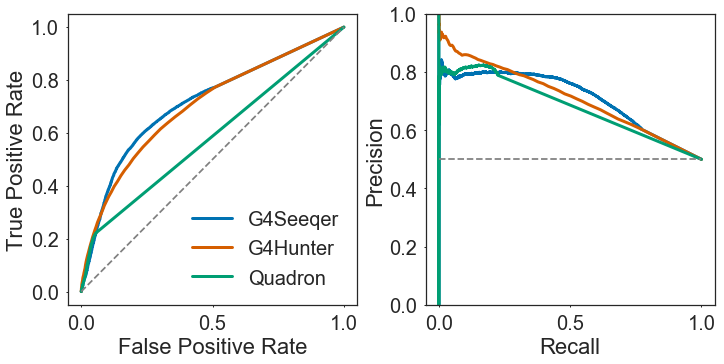

In [211]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
for s, lab in zip(['g4seeqer_score', 'g4hunter_score', 'quadron_score',],
                  ['G4Seeqer',  'G4Hunter', 'Quadron',]):
    fpr, tpr, threshold_roc = roc_curve(
        bg4_val_data.y_true, bg4_val_data[s])
    print(auc(fpr, tpr))
    axes[0].plot(fpr, tpr, label=lab, linewidth=3)
    prec, recl, threshold_pr = precision_recall_curve(
        bg4_val_data.y_true, bg4_val_data[s])
    axes[1].plot(recl, prec, linewidth=3)
axes[1].set_ylim(0, 1)
axes[0].plot([0, 1], [0, 1], ls='--', color='grey')
axes[1].plot([0, 1], [prec[0], prec[0]], ls='--', color='grey')
axes[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
axes[1].set(xlabel='Recall', ylabel='Precision')
axes[0].legend(loc=4, )
plt.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
plt.savefig('./figures/bg4_roc_pr.svg')
plt.show()